<a href="https://colab.research.google.com/github/YatingPan/Essentials-for-Text-and-Speech-Processing/blob/main/essential_project_yating_pan.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"

In [2]:
import torch

# Check if a GPU is available
if torch.cuda.is_available():
    device = torch.device("cuda")
    print("GPU is available")
    print("GPU:", torch.cuda.get_device_name(0))
else:
    device = torch.device("cpu")
    print("GPU is not available")

GPU is available
GPU: Tesla T4


# Part 1 Dataset Download and Exploration

## 1.1. Dataset Download

In [3]:
# Download IDMB dataset
!wget http://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz
!tar -xzf aclImdb_v1.tar.gz

--2023-10-26 14:22:18--  http://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz
Resolving ai.stanford.edu (ai.stanford.edu)... 171.64.68.10
Connecting to ai.stanford.edu (ai.stanford.edu)|171.64.68.10|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 84125825 (80M) [application/x-gzip]
Saving to: ‘aclImdb_v1.tar.gz.1’

aclImdb_v1.tar.gz.1 100%[===================>]  80.23M  16.7MB/s    in 8.1s    

2023-10-26 14:22:26 (9.89 MB/s) - ‘aclImdb_v1.tar.gz.1’ saved [84125825/84125825]



## 1.2. Dataset Exploration

In [4]:
import os

# Set the path to the dataset
path_to_dataset = 'aclImdb/train/pos/'

# Get a list of files in the dataset directory
file_names = os.listdir(path_to_dataset)

# Load and print the first few reviews
for file_name in file_names[:5]:
    with open(os.path.join(path_to_dataset, file_name), 'r', encoding='utf-8') as file:
        review = file.read()
        print(f'File: {file_name}\nReview: {review}\n')


File: 2946_10.txt
Review: I've never laughed and giggled so much in my life! The first half kept me in stitches; the last half made me come completely unglued! I think I giggled for 15 minutes after the tape was over.<br /><br />His timing and delivery for his stories is almost unequaled. And though he talks fast, you catch every joke. Which is probably why my "laugh center" was so overwhelmed; it took an extra 15 minutes to laugh at everything.<br /><br />

File: 2516_9.txt
Review: Based on the idea from Gackt, Moon Child took place in a poverty-stricken country called Mallepa. In a futuristic timeline, the story followed the lives of the two main characters, Kei (HYDE) and Sho (Gackt) and their friends growing up together.<br /><br />Despite some actions might be overly done or perhaps humorous, I strongly believed that this is a movie about friendship. Even amongst all the hardships between each character, in the end, each of them wanted to have someone on their side, to have friend

In [5]:
# Load the train and test datasets
train_dir = './aclImdb/train'
test_dir = './aclImdb/test'

# Lists to store samples and labels
train_texts, train_labels = [], []
test_texts, test_labels = [], []

# Load train data
for sentiment in ['pos', 'neg']:
    path = os.path.join(train_dir, sentiment)
    for filename in os.listdir(path):
        with open(os.path.join(path, filename), 'r', encoding='utf-8') as f:
            train_texts.append(f.read())
            train_labels.append(1 if sentiment == 'pos' else 0)

# Load test data
for sentiment in ['pos', 'neg']:
    path = os.path.join(test_dir, sentiment)
    for filename in os.listdir(path):
        with open(os.path.join(path, filename), 'r', encoding='utf-8') as f:
            test_texts.append(f.read())
            test_labels.append(1 if sentiment == 'pos' else 0)

# Print some samples and labels from the training data
print("Training Data Samples:")
for i in range(5):  # Print the first 5 samples
    print(f"Sample {i+1}:")
    print("Text:", train_texts[i])
    print("Label:", train_labels[i])
    print()

# Print some samples and labels from the test data
print("Test Data Samples:")
for i in range(5):  # Print the first 5 samples
    print(f"Sample {i+1}:")
    print("Text:", test_texts[i])
    print("Label:", test_labels[i])
    print()


Training Data Samples:
Sample 1:
Text: I've never laughed and giggled so much in my life! The first half kept me in stitches; the last half made me come completely unglued! I think I giggled for 15 minutes after the tape was over.<br /><br />His timing and delivery for his stories is almost unequaled. And though he talks fast, you catch every joke. Which is probably why my "laugh center" was so overwhelmed; it took an extra 15 minutes to laugh at everything.<br /><br />
Label: 1

Sample 2:
Text: Based on the idea from Gackt, Moon Child took place in a poverty-stricken country called Mallepa. In a futuristic timeline, the story followed the lives of the two main characters, Kei (HYDE) and Sho (Gackt) and their friends growing up together.<br /><br />Despite some actions might be overly done or perhaps humorous, I strongly believed that this is a movie about friendship. Even amongst all the hardships between each character, in the end, each of them wanted to have someone on their side, t

In [6]:
# Count the train and test dataset label distribution

from collections import Counter

# Count the distribution of labels in the training data
train_label_distribution = Counter(train_labels)

# Count the distribution of labels in the test data
test_label_distribution = Counter(test_labels)

# Print the label distributions
print("Training Data Label Distribution:")
print(train_label_distribution)

print("\nTest Data Label Distribution:")
print(test_label_distribution)


Training Data Label Distribution:
Counter({1: 12500, 0: 12500})

Test Data Label Distribution:
Counter({1: 12500, 0: 12500})


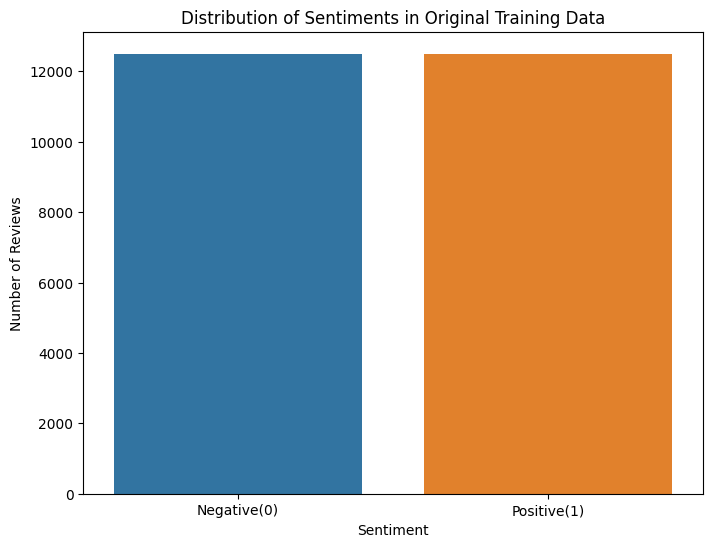

In [7]:
# Visualizing the distribution of sentiments in the original training

import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8,6))
sns.countplot(x=train_labels)
plt.title("Distribution of Sentiments in Original Training Data")
plt.xlabel("Sentiment")
plt.ylabel("Number of Reviews")
plt.xticks(ticks=[0,1], labels=['Negative(0)', 'Positive(1)'])
plt.show()



## 1.3. Dataset Resplit

As above distribution shows, the training and test datasets are splited as 50%-50% in the orignal dataset.

To achieve better training, here shuffle the data and resplit training and test dataset as 80%-20%.

In [8]:
# Shuffle and resplit training and test dataset
from sklearn.model_selection import train_test_split

# Combine all the texts and labels first
all_texts = train_texts + test_texts
all_labels = train_labels + test_labels

# Shuffle and split the dataset into 80-20 train-test
train_texts, test_texts, train_labels, test_labels = train_test_split(all_texts, all_labels, test_size=0.2, random_state=42)

# Print some samples and labels from the training data
print("Training Data Samples:")
for i in range(5):  # Print the first 5 samples
    print(f"Sample {i+1}:")
    print("Text:", train_texts[i])
    print("Label:", train_labels[i])
    print()

# Print some samples and labels from the test data
print("Test Data Samples:")
for i in range(5):  # Print the first 5 samples
    print(f"Sample {i+1}:")
    print("Text:", test_texts[i])
    print("Label:", test_labels[i])
    print()

# Count the train and test dataset label distribution
train_label_distribution = Counter(train_labels)
test_label_distribution = Counter(test_labels)

# Print the label distributions
print("Training Data Label Distribution:")
print(train_label_distribution)

print("\nTest Data Label Distribution:")
print(test_label_distribution)


Training Data Samples:
Sample 1:
Text: When they announced this movie for TNT I was excited. A Travesty from Donald Westlake's "Enough" was one of my all time favorite stories. After I watched it I was not all that thrilled. Recently I had the chance to watch it a second time with my aunt, and once again I was disappointed (she didn't like it much either, and she'd never read the book). In this movie they managed to sap all the charm from the book and turn it into dull mush. A big part of the problem was William H. Macy. I like him fine in other films, but he played (Terry/Carey) Thorpe as a stammering, incompetent yutz. In the book Thorpe takes a lot of valium for his nerves, but remains outwardly collected at almost all times which is part of the fun. SPOILERS follow: They also left out a big part of the story (other than a 2 second glimpse at the embassy), where Thorpe solves not 1 but 4 homicides for the police. This is important not just because it's funny, but because it helps se

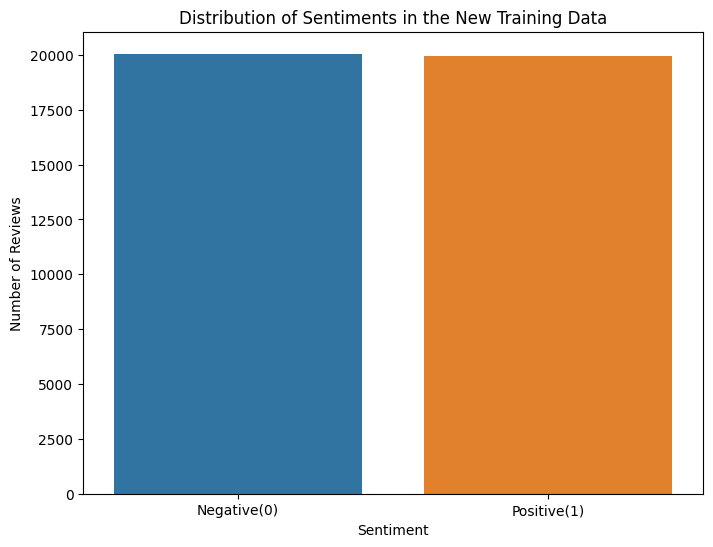

In [9]:
# Visualizing the distribution of sentiments in the new training dataset

import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8,6))
sns.countplot(x=train_labels)
plt.title("Distribution of Sentiments in the New Training Data")
plt.xlabel("Sentiment")
plt.ylabel("Number of Reviews")
plt.xticks(ticks=[0,1], labels=['Negative(0)', 'Positive(1)'])
plt.show()



# Part 2 Dataset Processing

## 2.1. Dataset Preprocessing:
Remove data duplicates.

Remove HTML tags.

Convert to lowercase.

Remove non-alphabets.

Remove stopwords.

In [10]:
from bs4 import BeautifulSoup
import re
import nltk
import spacy
import string
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from collections import Counter
from torch.utils.data import Dataset, DataLoader
from wordcloud import WordCloud
import matplotlib.pyplot as plt

In [11]:
# Downloading resources
nltk.download('punkt')
nltk.download('stopwords')

# Stopwords and punctuation
stop = set(stopwords.words('english'))
punctuations = list(string.punctuation)
stop.update(punctuations)

def preprocess_text(text):
    # Remove HTML tags
    soup = BeautifulSoup(text, "html.parser")
    text = soup.get_text()

    # Convert to lowercase and remove non-alphabets
    text = text.lower()
    text = re.sub('[^a-zA-Z]', ' ', text)

    # Remove stopwords
    text = word_tokenize(text)
    text = [word for word in text if word not in stop]

    return " ".join(text)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [12]:
# Preprocess texts
train_texts = [preprocess_text(text) for text in train_texts]
test_texts = [preprocess_text(text) for text in test_texts]

<ipython-input-11-048bf0633ae5>:12: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  soup = BeautifulSoup(text, "html.parser")


In [13]:
# Display some preprocessed samples for verification
print("Preprocessed Training Data Samples:")
for i in range(5):  # Print the preprocessed text for the first 5 samples
    print(f"Sample {i+1}:")
    print(train_texts[i])
    print()

Preprocessed Training Data Samples:
Sample 1:
announced movie tnt excited travesty donald westlake enough one time favorite stories watched thrilled recently chance watch second time aunt disappointed like much either never read book movie managed sap charm book turn dull mush big part problem william h macy like fine films played terry carey thorpe stammering incompetent yutz book thorpe takes lot valium nerves remains outwardly collected almost times part fun spoilers follow also left big part story second glimpse embassy thorpe solves homicides police important funny helps set relationship fred thorpe movie fred betrayal end nearly affecting seem close book become pretty good friends especially fred side makes ironic one arranges thorpe downfall fred also suffered bit casting love adam arkin cheerful happy alive upbeat sort detective character traits book fred possesses makes obviously character mess evidence thus shocking patricia edgarson pretty close book james cromwell great des

## 2.2. Tokenization

Tokenize the preprocessed text with NLTK

In [14]:
# Tokenization with nltk
tokenized_texts_train = [word_tokenize(text) for text in train_texts]
tokenized_texts_test = [word_tokenize(text) for text in test_texts]

## 2.3. Lemmatization

Lemmatize tokenized text with Spacy

In [15]:
# Lemmatization with Spacy
# nlp = spacy.load("en_core_web_sm")
# tokenized_texts_train = [[token.lemma_ for token in nlp(' '.join(tokens))] for tokens in tokenized_texts_train]
# tokenized_texts_test = [[token.lemma_ for token in nlp(' '.join(tokens))] for tokens in tokenized_texts_test]


In [16]:
# As above code stuck in running, here is the new code, which only loads the tokenizer and tagger (which are needed for lemmatization) from Spacy
nlp = spacy.load("en_core_web_sm", disable=["ner", "parser"])

def lemmatize_texts(texts):
    lemmatized_texts = []
    # Process texts in batches for efficiency
    for doc in nlp.pipe(texts, batch_size=1000):
        lemmatized_texts.append([token.lemma_ for token in doc])
    return lemmatized_texts

# Concatenate tokens back to text before lemmatization
train_texts_joined = [' '.join(tokens) for tokens in tokenized_texts_train]
test_texts_joined = [' '.join(tokens) for tokens in tokenized_texts_test]

# Lemmatize the texts
tokenized_texts_train = lemmatize_texts(train_texts_joined)
tokenized_texts_test = lemmatize_texts(test_texts_joined)


In [17]:
# Display some tokenized samples for verification
print("Tokenized Training Data Samples:")
for i in range(5):  # Print the tokenized text for the first 5 samples
    print(f"Sample {i+1}:")
    print(tokenized_texts_train[i])
    print()

Tokenized Training Data Samples:
Sample 1:
['announce', 'movie', 'tnt', 'excite', 'travesty', 'donald', 'westlake', 'enough', 'one', 'time', 'favorite', 'story', 'watch', 'thrill', 'recently', 'chance', 'watch', 'second', 'time', 'aunt', 'disappoint', 'like', 'much', 'either', 'never', 'read', 'book', 'movie', 'manage', 'sap', 'charm', 'book', 'turn', 'dull', 'mush', 'big', 'part', 'problem', 'william', 'h', 'macy', 'like', 'fine', 'film', 'play', 'terry', 'carey', 'thorpe', 'stammer', 'incompetent', 'yutz', 'book', 'thorpe', 'take', 'lot', 'valium', 'nerve', 'remain', 'outwardly', 'collect', 'almost', 'time', 'part', 'fun', 'spoiler', 'follow', 'also', 'leave', 'big', 'part', 'story', 'second', 'glimpse', 'embassy', 'thorpe', 'solve', 'homicide', 'police', 'important', 'funny', 'help', 'set', 'relationship', 'fred', 'thorpe', 'movie', 'fred', 'betrayal', 'end', 'nearly', 'affect', 'seem', 'close', 'book', 'become', 'pretty', 'good', 'friend', 'especially', 'fred', 'side', 'make', 'iro

## 2.4. Vocabulary Building and Encoding
Build vocabulary from tokenized and lemmatized text.

Encode texts with the built vocabulary

In [69]:
import numpy as np
from collections import Counter

# Building vocabulary and encoding
flat_tokens = [token for tokens in tokenized_texts_train for token in tokens]
word_freq = Counter(flat_tokens)
vocab = {word: idx for idx, (word, freq) in enumerate(word_freq.items())}

In [70]:
# Define the maximum sequence length you want
max_seq_length = 100  # Adjust this value based on your requirements

# Encode texts and apply padding
encoded_texts_train = []
for tokens in tokenized_texts_train:
    encoded = [vocab.get(token, 0) for token in tokens]  # Replace unknown words with 0
    if len(encoded) < max_seq_length:
        encoded += [0] * (max_seq_length - len(encoded))  # Pad with zeros if the sequence is shorter
    else:
        encoded = encoded[:max_seq_length]  # Truncate if the sequence is longer
    encoded_texts_train.append(encoded)

encoded_texts_test = []
for tokens in tokenized_texts_test:
    encoded = [vocab.get(token, 0) for token in tokens]  # Replace unknown words with 0
    if len(encoded) < max_seq_length:
        encoded += [0] * (max_seq_length - len(encoded))  # Pad with zeros if the sequence is shorter
    else:
        encoded = encoded[:max_seq_length]  # Truncate if the sequence is longer
    encoded_texts_test.append(encoded)

# Display some encoded samples for verification
print("\nEncoded Training Data Samples:")
for i in range(5):  # Print the encoded text for the first 5 samples
    print(f"Sample {i+1}:")
    print(encoded_texts_train[i])
    print()


Encoded Training Data Samples:
Sample 1:
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 12, 16, 9, 17, 18, 19, 20, 21, 22, 23, 24, 1, 25, 26, 27, 24, 28, 29, 30, 31, 32, 33, 34, 35, 36, 19, 37, 38, 39, 40, 41, 42, 43, 44, 45, 24, 42, 46, 47, 48, 49, 50, 51, 52, 53, 9, 32, 54, 55, 56, 57, 58, 31, 32, 11, 16, 59, 60, 42, 61, 62, 63, 64, 65, 66, 67, 68, 69, 42, 1, 69, 70, 71, 72, 73, 74, 75, 24, 76, 77, 78, 79, 80, 69]

Sample 2:
[153, 154, 155, 156, 8, 157, 8, 158, 8, 159, 1, 160, 155, 161, 115, 1, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 163, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 119, 105, 184, 160, 187, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

Sample 3:
[188, 189, 190, 186, 8, 112, 19, 191, 192, 193, 194, 13, 195, 196, 57, 197, 1, 198, 199, 200, 56, 77, 201, 202, 203, 204, 205, 206, 207, 14, 208, 209, 210, 77, 211,

In [87]:
# Display some encoded samples for verification
print("\nEncoded Training Data Samples:")
for i in range(5):  # Print the encoded text for the first 5 samples
    print(f"Sample {i+1}:")
    print(encoded_texts_train[i])
    print()


Encoded Training Data Samples:
Sample 1:
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 12, 16, 9, 17, 18, 19, 20, 21, 22, 23, 24, 1, 25, 26, 27, 24, 28, 29, 30, 31, 32, 33, 34, 35, 36, 19, 37, 38, 39, 40, 41, 42, 43, 44, 45, 24, 42, 46, 47, 48, 49, 50, 51, 52, 53, 9, 32, 54, 55, 56, 57, 58, 31, 32, 11, 16, 59, 60, 42, 61, 62, 63, 64, 65, 66, 67, 68, 69, 42, 1, 69, 70, 71, 72, 73, 74, 75, 24, 76, 77, 78, 79, 80, 69]

Sample 2:
[153, 154, 155, 156, 8, 157, 8, 158, 8, 159, 1, 160, 155, 161, 115, 1, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 163, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 119, 105, 184, 160, 187, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

Sample 3:
[188, 189, 190, 186, 8, 112, 19, 191, 192, 193, 194, 13, 195, 196, 57, 197, 1, 198, 199, 200, 56, 77, 201, 202, 203, 204, 205, 206, 207, 14, 208, 209, 210, 77, 211,

In [71]:
# Convert encoded texts to NumPy arrays
X_train = np.array(encoded_texts_train)
X_test = np.array(encoded_texts_test)

In [74]:
# Convert labels to NumPy arrays
y_train = np.array(train_labels)
y_test = np.array(test_labels)

In [75]:
# Display some encoded samples for verification
print("\nEncoded Training Data Samples:")
for i in range(5):  # Print the encoded text for the first 5 samples
    print(f"Sample {i+1}:")
    print(X_train[i])
    print()



Encoded Training Data Samples:
Sample 1:
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 12 16  9 17 18 19 20 21
 22 23 24  1 25 26 27 24 28 29 30 31 32 33 34 35 36 19 37 38 39 40 41 42
 43 44 45 24 42 46 47 48 49 50 51 52 53  9 32 54 55 56 57 58 31 32 11 16
 59 60 42 61 62 63 64 65 66 67 68 69 42  1 69 70 71 72 73 74 75 24 76 77
 78 79 80 69]

Sample 2:
[153 154 155 156   8 157   8 158   8 159   1 160 155 161 115   1 162 163
 164 165 166 167 168 169 170 171 163 172 173 174 175 176 177 178 179 180
 181 182 183 184 185 186 119 105 184 160 187   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0]

Sample 3:
[188 189 190 186   8 112  19 191 192 193 194  13 195 196  57 197   1 198
 199 200  56  77 201 202 203 204 205 206 207  14 208 209 210  77 211 212
 213 214 215 186   8 216 217 218 219   8  87 220 221  31 222 223 224 225
 196

## 2.5. Datset Loading

Load the preprocessed dataset into Pytorch

In [104]:
import torch
from torch.utils.data import Dataset, DataLoader

# Define the TextDataset class
class TextDataset(Dataset):
    def __init__(self, texts, labels):
        self.texts = texts
        self.labels = labels

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        return torch.tensor(self.texts[idx], dtype=torch.long), torch.tensor(self.labels[idx], dtype=torch.float)

# Define a collate function to handle variable-length sequences
def collate_fn(batch):
    texts, labels = zip(*batch)
    text_lengths = [len(text) for text in texts]
    max_length = max(text_lengths)

    # Pad sequences to the maximum length in the batch
    padded_texts = [torch.cat([text, torch.zeros(max_length - len(text), dtype=torch.long)]) for text in texts]

    return torch.stack(padded_texts), torch.stack(labels), torch.tensor(text_lengths)

BATCH_SIZE = 25

# Create datasets and data loaders
train_dataset = TextDataset(encoded_texts_train, train_labels)
test_dataset = TextDataset(encoded_texts_test, test_labels)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_fn)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, collate_fn=collate_fn)


In [105]:
# Check a batch from the train_loader to verify everything
sample_batch_texts, sample_batch_labels, sample_batch_lengths = next(iter(train_loader))

print("Sample Batch Texts:")
print(sample_batch_texts)
print("\nSample Batch Texts Shape:", sample_batch_texts.shape)  # [batch_size, seq_length]

print("\nSample Batch Labels:")
print(sample_batch_labels)
print("Sample Batch Labels Shape:", sample_batch_labels.shape)  # [batch_size]

print("\nSample Batch Text Lengths:")
print(sample_batch_lengths)
print("Sample Batch Text Lengths Shape:", sample_batch_lengths.shape)  # [batch_size]

# Check if the padding is done correctly
print("\nAre text lengths equal to the lengths in 'sample_batch_lengths'?")
for idx, (text, length) in enumerate(zip(sample_batch_texts, sample_batch_lengths)):
    if idx >= 5:  # print only the first 5 for brevity
        break
    print(f"Text {idx+1} Length: {len(text.nonzero())} | Recorded Length: {length.item()}")


Sample Batch Texts:
tensor([[    8,     1,   138,  ...,     0,     0,     0],
        [  504, 12971,  2517,  ...,     0,     0,     0],
        [ 5652,  9978,  1101,  ...,   384,   829, 27635],
        ...,
        [76709,  1229,   191,  ...,     0,     0,     0],
        [   19,  1445,   635,  ...,     0,     0,     0],
        [   78,   181,     1,  ...,   888,  5150, 53438]])

Sample Batch Texts Shape: torch.Size([25, 100])

Sample Batch Labels:
tensor([1., 0., 1., 0., 1., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 1.,
        0., 0., 1., 0., 1., 0., 1.])
Sample Batch Labels Shape: torch.Size([25])

Sample Batch Text Lengths:
tensor([100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100,
        100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100])
Sample Batch Text Lengths Shape: torch.Size([25])

Are text lengths equal to the lengths in 'sample_batch_lengths'?
Text 1 Length: 87 | Recorded Length: 100
Text 2 Length: 64 | Recorded Length: 100
Text 3 Length: 100

# Part 3 Word Cloud Visualization

Before establishing the model, let's display the word cloud to quickly visualize the dataset!

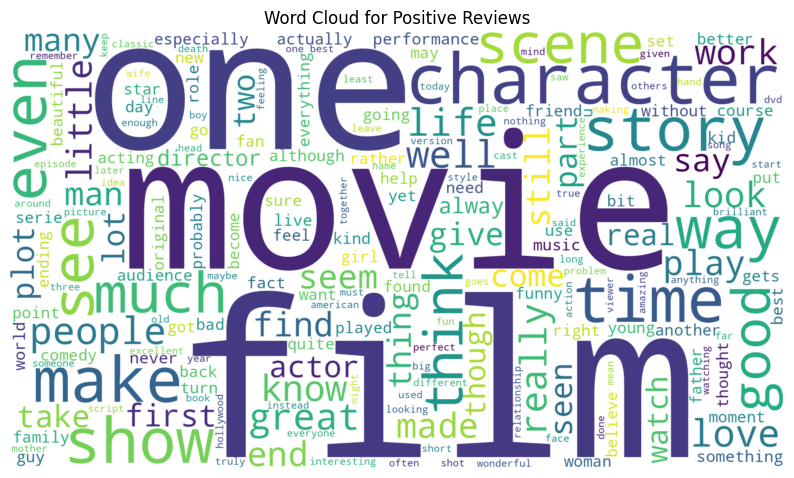

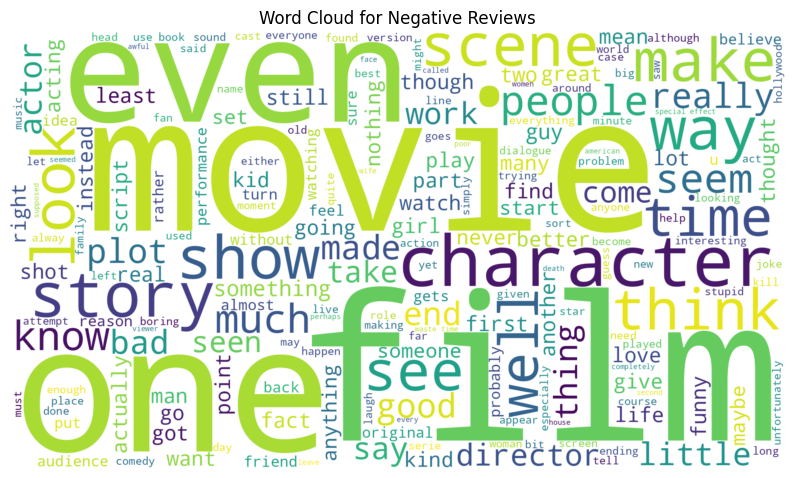

In [106]:
# Word Cloud for Positive and Negative Reviews in training dataset
def create_wordcloud(texts, title):
    wordcloud = WordCloud(width=1920, height=1080, background_color="white").generate(" ".join(texts))
    plt.figure(figsize=(10, 10))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(title)
    plt.axis('off')
    plt.show()

positive_texts = [text for idx, text in enumerate(train_texts) if train_labels[idx] == 1]
negative_texts = [text for idx, text in enumerate(train_texts) if train_labels[idx] == 0]

create_wordcloud(positive_texts, "Word Cloud for Positive Reviews")
create_wordcloud(negative_texts, "Word Cloud for Negative Reviews")

# Part 4 Model Establishment and Training

In this part, let's establish the following 4 models to implement experiments. These 4 models align with the progression of NLP models for sentiment analysis.

1. Traditional Machine Learning Methods

  Model 01: Logistic Regression

  Model 02: SVM

2. Deep Learning Methods

  Model 01: LSTM model

  Model 02: Transformer (BERT) model

3. Large Language Models (Optional)

  Here we use ChatGPT API for this task (if possible)

## 4.1. Traditional Machine Learning Method

### Data Re-preparation and TF-IDF

We need to re-prepare our data and do TF-IDF vectorization

In [26]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import train_test_split


In [27]:
# Merge train and test texts for TF-IDF vectorization
all_texts = train_texts + test_texts

# TF-IDF Vectorization
vectorizer = TfidfVectorizer(max_features=5000)  # Limiting to 5000 most frequent words for demonstration
X = vectorizer.fit_transform(all_texts)

# Splitting the dataset again
X_train = X[:len(train_texts)]
X_test = X[len(train_texts):]

# Train-Test Split (80-20)
X_train_split, X_val_split, y_train_split, y_val_split = train_test_split(X_train, train_labels, test_size=0.2, random_state=42)

### Model 01: Logistic Regression

In [30]:
# Model 01: Logistic Regression
log_reg = LogisticRegression(max_iter=1000)
log_reg.fit(X_train_split, y_train_split)

# Validation
y_pred_val_log_reg = log_reg.predict(X_val_split)
print("Logistic Regression - Validation Results:")
print(classification_report(y_val_split, y_pred_val_log_reg))


Logistic Regression - Validation Results:
              precision    recall  f1-score   support

           0       0.89      0.88      0.89      3979
           1       0.88      0.90      0.89      4021

    accuracy                           0.89      8000
   macro avg       0.89      0.89      0.89      8000
weighted avg       0.89      0.89      0.89      8000



### Model 02: SVM

In [29]:
# Model 02: SVM (or Linear SVM)
linear_svm = LinearSVC(max_iter=1000)
linear_svm.fit(X_train_split, y_train_split)

# Validation
y_pred_val_svm = linear_svm.predict(X_val_split)
print("Linear SVM - Validation Results:")
print(classification_report(y_val_split, y_pred_val_svm))

Linear SVM - Validation Results:
              precision    recall  f1-score   support

           0       0.88      0.87      0.88      3979
           1       0.88      0.88      0.88      4021

    accuracy                           0.88      8000
   macro avg       0.88      0.88      0.88      8000
weighted avg       0.88      0.88      0.88      8000



## 4.2. Deep Learning Methods

### Model 03: LSTM

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim


class LSTMClassifier(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes):
        super(LSTMClassifier, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.embedding = nn.Embedding(input_size, hidden_size)
        self.lstm = nn.LSTM(hidden_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        # Embedding layer
        x = self.embedding(x)

        # LSTM layer
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        out, _ = self.lstm(x, (h0, c0))

        # Final fully connected layer
        out = self.fc(out[:, -1, :])  # Get the output of the last time step
        return out


In [2]:
print("Verification before training:")
print("Number of training samples:", len(train_dataset))
print("Number of test samples:", len(test_dataset))

Verification before training:


NameError: ignored

In [109]:
# Check a batch from the train_loader to verify the data
sample_batch_texts, sample_batch_labels, sample_batch_lengths = next(iter(train_loader))

print("\nSample Batch Texts:")
print(sample_batch_texts)
print("\nSample Batch Texts Shape:", sample_batch_texts.shape)  # [batch_size, seq_length]

print("\nSample Batch Labels:")
print(sample_batch_labels)
print("Sample Batch Labels Shape:", sample_batch_labels.shape)  # [batch_size]

print("\nSample Batch Text Lengths:")
print(sample_batch_lengths)
print("Sample Batch Text Lengths Shape:", sample_batch_lengths.shape)  # [batch_size]


Sample Batch Texts:
tensor([[  303,  3031,   677,  ...,   450,   203, 47319],
        [   82,  3640,     1,  ...,     0,     0,     0],
        [ 5687,   181,   642,  ...,     0,     0,     0],
        ...,
        [  549,    38,  8264,  ...,     0,     0,     0],
        [ 2195,  2196,  3332,  ...,    11,   662,  1762],
        [ 3745,   187,    12,  ...,     0,     0,     0]])

Sample Batch Texts Shape: torch.Size([25, 100])

Sample Batch Labels:
tensor([0., 0., 1., 1., 0., 1., 1., 1., 0., 0., 1., 1., 0., 0., 0., 1., 0., 1.,
        0., 0., 1., 0., 1., 1., 0.])
Sample Batch Labels Shape: torch.Size([25])

Sample Batch Text Lengths:
tensor([100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100,
        100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100])
Sample Batch Text Lengths Shape: torch.Size([25])


In [110]:
input_size = len(vocab)  # Size of your vocabulary
hidden_size = 256
num_layers = 2
num_classes = 2  # Adjust this based on the number of classes in your classification task

model = LSTMClassifier(input_size, hidden_size, num_layers, num_classes)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

print("Input size:", input_size)

Input size: 80179


In [112]:
num_epochs = 10  # Adjust this based on the desired number of training epochs

for epoch in range(num_epochs):
    model.train()
    total_loss = 0

    for texts, labels, lengths in train_loader:
        optimizer.zero_grad()

        # Print some information for debugging
        print(f"Batch Texts Shape: {texts.shape}")
        print(f"Batch Labels Shape: {labels.shape}")
        print(f"Batch Text Lengths Shape: {lengths.shape}")

        assert texts.shape[1] == max_seq_length, "Texts have incorrect sequence length"
        assert texts.shape[0] == labels.shape[0], "Number of texts and labels mismatch"
        assert texts.shape[0] == lengths.shape[0], "Number of texts and lengths mismatch"

        outputs = model(texts)
        loss = criterion(outputs, labels.long())
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    # Print the average loss for this epoch
    print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {total_loss / len(train_loader)}')


Batch Texts Shape: torch.Size([25, 100])
Batch Labels Shape: torch.Size([25])
Batch Text Lengths Shape: torch.Size([25])


RuntimeError: ignored

### Model 04: Transformer (BERT)

Here we directly use BERT, which is one of the most State-Of-The-Art Transformer based model for NLP tasks

In [36]:
!pip install transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.7/7.7 MB 26.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.0/302.0 kB 38.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.8/3.8 MB 69.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 77.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 295.0/295.0 kB 31.6 MB/s eta 0:00:00


In [37]:
from transformers import BertTokenizer, BertForSequenceClassification

# Load BERT tokenizer and model
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertForSequenceClassification.from_pretrained('bert-base-uncased')

# Tokenize data
encoded_data_train = tokenizer.batch_encode_plus(train_texts_str, add_special_tokens=True, return_attention_mask=True, pad_to_max_length=True, max_length=256, return_tensors='pt')
encoded_data_test = tokenizer.batch_encode_plus(test_texts_str, add_special_tokens=True, return_attention_mask=True, pad_to_max_length=True, max_length=256, return_tensors='pt')

input_ids_train = encoded_data_train['input_ids']
attention_masks_train = encoded_data_train['attention_mask']
labels_train = torch.tensor(train_labels)

input_ids_test = encoded_data_test['input_ids']
attention_masks_test = encoded_data_test['attention_mask']
labels_test = torch.tensor(test_labels)


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2606: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In t

# Part 5 Model Training

## 5.1. Train LSTM

In [38]:
import torch.optim as optim

# Criterion & Optimizer
criterion = torch.nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters())

# Move model to GPU
model = model.to(device)
criterion = criterion.to(device)

# Train function
def train(model, iterator, optimizer, criterion):
    model.train()
    epoch_loss = 0
    for batch in iterator:
        text, labels, _ = batch
        text, labels = text.to(device), labels.to(device)
        optimizer.zero_grad()
        predictions = model(text).squeeze(1)
        loss = criterion(predictions, labels.float())
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
    return epoch_loss / len(iterator)

# Training loop
N_EPOCHS = 5
for epoch in range(N_EPOCHS):
    train_loss = train(model, train_loader, optimizer, criterion)
    print(f'Epoch: {epoch+1:02}, Train Loss: {train_loss:.3f}')


We strongly recommend passing in an `attention_mask` since your input_ids may be padded. See https://huggingface.co/docs/transformers/troubleshooting#incorrect-output-when-padding-tokens-arent-masked.


RuntimeError: ignored